In [12]:
from __future__ import  division, print_function, absolute_import
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mne
from sklearn.model_selection import cross_val_score
from mne.io import RawArray
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs
from mne.channels import read_custom_montage
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import warnings
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import welch
from mne import pick_types

import os.path
from mne.decoding import CSP
import scipy.io as sio
auc = []
warnings.filterwarnings('ignore')
##########################
# create MNE readable file 
##########################
def creat_mne_raw_object(fname):
    """Create a mne raw instance from csv file"""
    # Read EEG file
    data = pd.read_csv(fname)
    
    # get chanel names
    ch_names = list(data.columns[1:])
    
    # read EEG standard montage from mne
    montage = 'standard_1005'

    # events file
    ev_fname = fname.replace('_data','_events')
    # read event file
    events = pd.read_csv(ev_fname)
    events_names = events.columns[1:]
    events_data = np.array(events[events_names]).T
    
    # concatenate event file and data
    data = np.concatenate((1e-6*np.array(data[ch_names]).T,events_data))        
    
    # define channel type, the first is EEG, the last 6 are stimulations
    ch_type = ['eeg']*len(ch_names) + ['stim']*6
    
    # create and populate MNE info structure
    ch_names.extend(events_names)
    info = create_info(ch_names,sfreq=500.0,ch_types=ch_type)
    info.set_montage(montage)
    #info['filename'] = fname
    
    # create raw object 
    raw = RawArray(data,info,verbose=False)
    return raw


In [13]:
####################################################################
# Data preprocessing, band_pass, event related 1.5s + 1.5s featuring
####################################################################
def data_gen(subjects):    
    X_train=[]
    y_train=[]
    n = 0

    for i in range(len(subjects)):
        n+=1
        subject = subjects[i]
        epochs_Replace_tot = []
        epochs_Replace_rest_tot = []
        epochs_HandStart_tot = []
        epochs_HandStart_rest_tot = []

        fnames =  glob('../EEG/train/subj%d_series*_data.csv' % (subject))

        y = []
        for i,fname in enumerate(fnames):

            # read data 
            raw = creat_mne_raw_object(fname)
            #raw.plot(block=True)
            # pick eeg signal
            picks = pick_types(raw.info,eeg=True)

            # Filter data for alpha frequency and beta band
            # Note that MNE implement a zero phase (filtfilt) filtering not compatible
            # with the rule of future data.
            raw.filter(7,35, picks=picks, method='iir', n_jobs=-1, verbose=False)

            #id = 'Replace'
            # get event posision corresponding to Replace
            events = find_events(raw,stim_channel='Replace', verbose=False)
            # epochs signal for 1.5 second before the movement
            epochs = Epochs(raw, events, {'during' : 1}, -2, -0.5, proj=False, picks=picks, baseline=None, preload=True, verbose=False)

            epochs_Replace_tot.append(epochs)


            # epochs signal for 1.5 second after the movement, this correspond to the 
            # rest period.
            epochs_rest = Epochs(raw, events, {'after' : 1}, 0.5, 2, proj=False, picks=picks, baseline=None, preload=True, verbose=False)

            # Workaround to be able to concatenate epochs
            epochs_rest.shift_time(-2.5, relative = True)

            epochs_Replace_rest_tot.append(epochs_rest)

            # id = 'HandStart'
            # get event posision corresponding to HandStart
            events = find_events(raw,stim_channel='HandStart', verbose=False)
            # epochs signal for 1.5 second before the movement
            epochs = Epochs(raw, events, {'during' : 1}, 0.5, 2, proj=False, picks=picks, baseline=None, preload=True, verbose=False)

            epochs_HandStart_tot.append(epochs)

            # epochs signal for 1.5 second after the movement, this correspond to the 
            # rest period.
            epochs_rest = Epochs(raw, events, {'before' : 1}, -2, -0.5, proj=False, picks=picks, baseline=None, preload=True, verbose=False)

            # Workaround to be able to concatenate epochs
            epochs_rest.shift_time(2.5, relative = True)

            epochs_HandStart_rest_tot.append(epochs_rest)


        epochs_Replace = concatenate_epochs(epochs_Replace_tot)
        epochs_Replace_rest = concatenate_epochs(epochs_Replace_rest_tot)
        epochs_HandStart = concatenate_epochs(epochs_HandStart_tot)
        epochs_HandStart_rest = concatenate_epochs(epochs_HandStart_rest_tot)
    
        # epochs.plot_psd( fmin=2.,fmax=40.,average=True, spatial_colors=True)
        # epochs_rest.plot_psd( fmin=2.,fmax=40.,average=True, spatial_colors=True)

        # epochs.plot_psd_topomap(ch_type='eeg',normalize=True)
        # epochs_rest.plot_psd_topomap(ch_type='eeg',normalize=True)

        #get data 
        X_Replace = epochs_Replace.get_data()
        X_Replace_rest = epochs_Replace_rest.get_data()
        X_Replace_var = np.concatenate((X_Replace,X_Replace_rest),axis=2)

        X_HandStart = epochs_HandStart.get_data()
        X_HandStart_rest = epochs_HandStart_rest.get_data()
        X_HandStart_var = np.concatenate((X_HandStart_rest,X_HandStart),axis=2)

        X = np.concatenate((X_Replace_var,X_HandStart_var),axis=0)
        #y = np.array(y)
        print ("subject",subject,X.shape)

        if n == 1:
            X_train = X

        else:
            X_train=np.append(X_train,X,axis =0)

        y = np.concatenate((np.ones(260),np.zeros(260)),axis=0)
        y_train = np.concatenate((y_train,y),axis=0)
        print ("data stack shape:",X_train.shape,y_train.shape)

    # generate feature dataset for next process, it contains (HandStar,rest),(Replace,rest) 
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    print ('return data shape: ',X_train.shape,y_train.shape)
    return (X_train, y_train)


subject 2 (520, 32, 1502)
data stack shape: (520, 32, 1502) (520,)
subject 3 (520, 32, 1502)
data stack shape: (1040, 32, 1502) (1040,)
subject 4 (520, 32, 1502)
data stack shape: (1560, 32, 1502) (1560,)
subject 5 (520, 32, 1502)
data stack shape: (2080, 32, 1502) (2080,)
subject 6 (520, 32, 1502)
data stack shape: (2600, 32, 1502) (2600,)
subject 7 (520, 32, 1502)
data stack shape: (3120, 32, 1502) (3120,)
subject 8 (520, 32, 1502)
data stack shape: (3640, 32, 1502) (3640,)
subject 9 (520, 32, 1502)
data stack shape: (4160, 32, 1502) (4160,)
subject 10 (520, 32, 1502)
data stack shape: (4680, 32, 1502) (4680,)
subject 11 (520, 32, 1502)
data stack shape: (5200, 32, 1502) (5200,)
subject 12 (520, 32, 1502)
data stack shape: (5720, 32, 1502) (5720,)
return data shape:  (5720, 32, 1502) (5720,)
subject 1 (520, 32, 1502)
data stack shape: (520, 32, 1502) (520,)
return data shape:  (520, 32, 1502) (520,)
Computing rank from data with rank=None
    Using tolerance 0.0034 (2.2e-16 eps * 32 

Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 32 dim * 1.9e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0013 (2.2e-16 eps * 32 dim * 1.8e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0013 (2.2e-16 eps * 32 dim * 1.9e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Usi

    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.0034 (2.2e-16 eps * 32 dim * 4.7e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.0032 (2.2e-16 eps * 32 dim * 4.5e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using LEDOIT_WOLF
Done.
csp trained
Computing rank from data with rank=None
    Using tolerance 0.00098 (2.2e-16 eps * 32 dim * 1.4e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing d

    Using tolerance 0.00082 (2.2e-16 eps * 32 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00078 (2.2e-16 eps * 32 dim * 1.1e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Subject 5 : AUC cross val score : 0.759
subject 1 (520, 32, 1502)
data stack shape: (520, 32, 1502) (520,)
subject 2 (520, 32, 1502)
data stack shape: (1040, 32, 1502) (1040,)
subject 3 (520, 32, 1502)
data stack shape: (1560, 32, 1502) (1560,)
subject 4 (520, 32, 1502)
data stack shape: (2080, 32, 1502) (2080,)
subject 5 (520, 32, 1502)
data stack shape: (2600, 32, 1502) (2600,)
subject 7 (520, 32, 1502)
data stack shape: (3120, 32, 1502) (3120,)
su

    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0011 (2.2e-16 eps * 32 dim * 1.6e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.001 (2.2e-16 eps * 32 dim * 1.5e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0011 (2.2e-16 eps * 32 dim * 1.6e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance usin

subject 11 (520, 32, 1502)
data stack shape: (5200, 32, 1502) (5200,)
subject 12 (520, 32, 1502)
data stack shape: (5720, 32, 1502) (5720,)
return data shape:  (5720, 32, 1502) (5720,)
subject 9 (520, 32, 1502)
data stack shape: (520, 32, 1502) (520,)
return data shape:  (520, 32, 1502) (520,)
Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 32 dim * 4.9e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.0033 (2.2e-16 eps * 32 dim * 4.6e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 32 dim * 4.9e+11  max singular valu

Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0008 (2.2e-16 eps * 32 dim * 1.1e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00077 (2.2e-16 eps * 32 dim * 1.1e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0008 (2.2e-16 eps * 32 dim * 1.1e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Us

    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using LEDOIT_WOLF
Done.
csp trained
Computing rank from data with rank=None
    Using tolerance 0.001 (2.2e-16 eps * 32 dim * 1.5e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.001 (2.2e-16 eps * 32 dim * 1.4e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.001 (2.2e-16 eps * 32 dim * 1.5e+11  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank

<Figure size 288x288 with 0 Axes>

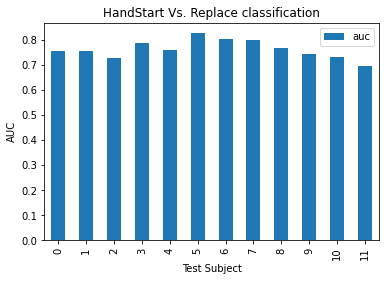

In [14]:
for j in range(1,13):
    train_subject = [k for k in range(1,13) if k != j]
    test_subject = [j]
    train_X,train_y = data_gen(train_subject)
    test_X,test_y = data_gen(test_subject)
    
    idx = list(range(len(train_y)))
    np.random.shuffle(idx)
    train_X = train_X[idx]
    train_y = train_y[idx]
    
    idx = list(range(len(test_y)))
    np.random.shuffle(idx)
    test_X = test_X[idx]
    test_y = test_y[idx]
    #sio.savemat('/home/yaoxiaojian/Desktop/kaggle/EEG/TACR_independent_2-class/T-set_sub'+str(j)+'.mat', {"train_x": train_X, "train_y": train_y, "test_x": test_X, "test_y": test_y})
    
    csp = CSP(reg='ledoit_wolf') #0.20 changed from 'lws' to 'ledoit_wolf'
    csp.fit(train_X,train_y)
    csp.fit_transform(train_X, train_y)
    
    print ('csp trained')
    clf = make_pipeline(CSP(),LogisticRegression())
    auc.append(cross_val_score(clf,test_X,test_y,scoring='roc_auc').mean())
    print("Subject %d : AUC cross val score : %.3f" % (j,auc[-1]))

auc = pd.DataFrame(data=auc,columns=['auc'])
auc.to_csv('csp_independent.csv')
plt.figure(figsize=(4,4))
auc.plot(kind='bar',y='auc')
plt.xlabel('Test Subject')
plt.ylabel('AUC')
plt.title('HandStart Vs. Replace classification')
plt.savefig('csp_independent.png' ,bbox_inches='tight') 

